# py4DSTEM Tutorial - CoM Differential Phase Contrast Reconstruction
---

### Introduction

This is a tutorial notebook intended to teach you how to use py4DSTEM to perform a differential phase contrast (DPC) reconstruction from a 4D-STEM dataset. The steps we will perform are:

* [Part 0 - Download and load the 4D-STEM dataset.](#part_00)
* [Part 1 - Calculate the center-of-mass (CoM) for each probe position.](#part_01)
* [Part 2 - Determine the relative rotation between the scan direction and the diffraction space images.](#part_02)
* [Part 3 - Reconstruct the differential phase contrast (DPC) signal.](#part_03)

A deep knowledge of the theory of DPC imaging is not required for this tutorial. All you need to know is that (given some assumptions) when a STEM probe passes through a sample potential, the STEM probe will deflect in the direction of the gradient of this potential. In a far field (diffraction space) measurement, we can directly measure the average momentum change of a STEM probe as a 2-element vector by taking the CoM of the electron counts. To reconstruct the sample's potential, we simply need to invert this 2D gradient measurement.

For more information on the history and theory of DPC, and the algorithm used in py4DSTEM, see the following references:
* N Dekkers & H De Lang, [Differential phase contrast in a STEM](http://xrm.phys.northwestern.edu/research/pdf_papers/1974/dekkers_optik_1974.pdf), Optik 41, 452–456 (1974).
* A Lubk & J Zweck. [Differential phase contrast: An integral perspective](https://doi.org/10.1103/PhysRevA.91.023805), Phys Rev A 91, 023805 (2015).
* B Savitzky et al., [py4DSTEM: A Software Package for Four-Dimensional Scanning Transmission Electron Microscopy Data Analysis](https://doi.org/10.1017/S1431927621000477), Microscopy and Microanalysis (2021).

### Acknowledgements

This tutorial was written by Colin Ophus at Berkeley Lab (clophus@lbl.gov).

The 4D-STEM dataset used here is from Hao Yang, Pete Nellist, and collaborators, from this reference:
* Yang, H, Rutte, R, Jones, L, Simson, M, Sagawa, R, Ryll, H, Huth, M, Pennycook, T, Green, M, Soltau, H, Kondo, Y, Davis, BG & Nellist, PD (2016 b). [Simultaneous atomic-resolution electron ptychography and Z-contrast imaging of light and heavy elements in complex nanostructures](https://doi.org/10.1038/ncomms12532) Nature Communications  7, 12532 (2016) 


### Version
Last updated on 2021-06-01 with py4DSTEM version 0.12.0.

---
# Part 0 - Download the datasets used in this tutorial <a class="anchor" id="part_00"></a>

You can download the tutorial dataset here: (945 megabytes)
* [Filled Carbon Nanotube](https://drive.google.com/file/d/1bHv3u61Cr-y_GkdWHrJGh1lw2VKmt3UM/view?usp=sharing)

Once you have downloaded this data, update the variable `file_path_input` in the next cell to reflect that path to the file on your computer.

In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# Initialization - import the needed packages.
# For this tutorial, we will need py4DSTEM, numpy, and h5py
import py4DSTEM
import numpy as np
import h5py    

In [81]:
# Set the file paths for the input datasets.
# The location of these files may be different, depending on your operating system and browser download path.
# If you are running this tutorial on Binder, you do not need to change this path.
file_path_input = 'c:/data/carbon_nanotube_data.h5'

In [82]:
# This dataset is stored in an HDF5 file, but is different from the current native py4DSTEM HDF5 / h5 format.

# So, our first step is to list all of the groups inside the .h5 file: (code adapted from issue #406 on the h5py github repo)
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print('%s %s' % (key, val))

f = h5py.File(file_path_input,'r')
f.visititems(print_attrs)

4D-STEM_data
4D-STEM_data/metadata
4D-STEM_data/metadata/calibration
K_pix_size [0.6233536 0.6233536]
K_pix_units b'angstrom^-1'
R_pix_size [0.28 0.28]
R_pix_units b'angstrom'
R_to_K_rotation_degrees 8
4D-STEM_data/metadata/comments
4D-STEM_data/metadata/microscope
accelerating_voltage 80000.0
convergence_semiangle_mrad 26.029473684210526
4D-STEM_data/metadata/original
4D-STEM_data/metadata/original/all
4D-STEM_data/metadata/original/shortlist
4D-STEM_data/metadata/processing
4D-STEM_data/metadata/sample
4D-STEM_data/metadata/user
4DSTEM_experiment
4DSTEM_experiment/data
4DSTEM_experiment/data/datacubes
emd_group_type 1
4DSTEM_experiment/data/datacubes/datacube_0
4DSTEM_experiment/data/datacubes/datacube_0/datacube
4DSTEM_experiment/data/diffractionslices
4DSTEM_experiment/data/pointlistarrays
4DSTEM_experiment/data/pointlists
4DSTEM_experiment/data/realslices


There are many `groups`, `datasets`, and `attributes` inside this .h5 file. However, we require only one, named:

`4DSTEM_experiment/data/datacubes/datacube_0/datacube`

In [83]:
# The next step is to import this experiment as a py4DSTEM datacube.
dataset = py4DSTEM.io.DataCube(data=f['4DSTEM_experiment']['data']['datacubes']['datacube_0']['datacube'])

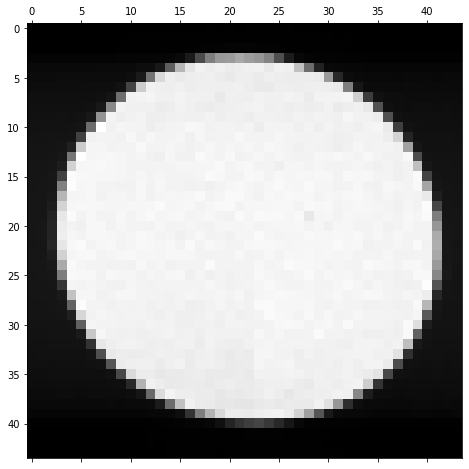

In [84]:
# Let's examine the mean diffraction space image, by taking the average over all probe positions:
diffraction_pattern_mean = np.mean(dataset.data, axis=(0,1))
py4DSTEM.visualize.show(diffraction_pattern_mean)

In the mean diffraction pattern image, we can clearly see the initial STEM probe. For a thin specimen, most of the electrons will remain inside the bright field (BF) disk, i.e. the angular range of the initial STEM beam). This means that changing the TEM camera length or cropping the dataset around the BF disk is reasonable, as is the case here.

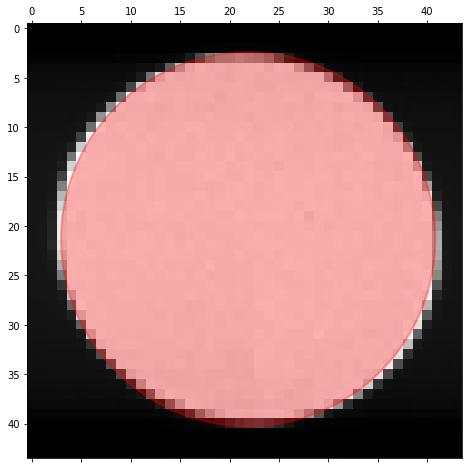

Estimated probe radius = 18.93 pixels


In [85]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, qx0, qy0 = py4DSTEM.process.calibration.get_probe_size(diffraction_pattern_mean)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(diffraction_pattern_mean, (qx0, qy0), probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

By overlaying a circle, we can see a common artifact in STEM simulations: ellipticity of either the original probe aperture, or the projecter system of the TEM. This ellipticity will not affect our DPC measurement, although we should be careful to use a large enough virtual detector / cropping range to fully capture the BF signal for all probe positions.

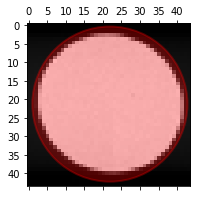

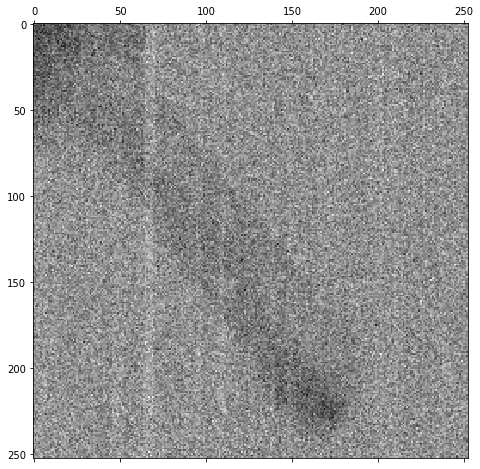

In [104]:
# Next, create a bright field (BF) virtual detector using the the center beam position, and expanding the radius slightly (+ 2 px).
expand_BF = 2.0
image_BF = py4DSTEM.process.virtualimage.get_virtualimage_circ(dataset, qx0, qy0, probe_semiangle + expand_BF)

# Show the BF image, next to the virtual detector we have used
py4DSTEM.visualize.show_circles(diffraction_pattern_mean, (qx0, qy0), probe_semiangle + expand_BF, figsize=(3,3))
py4DSTEM.visualize.show(image_BF)

Virtually no contrast is visible in the virtual BF image - this image contrast roughly corresponds to the `amplitude` of the sample's exit wave. In the following sections, we will use CoM-DPC to measute the `phase`, which will hopefully produce significantly more signal in the image.

---
# Part 1 - Calculate the center-of-mass (CoM) for each probe position. <a class="anchor" id="part_01"></a>

In this section, we will compute the (qx_shift, qy_shift) momentum vector estimate for all probe positions. We accomplish this by computing the first moment of the intentisty distribution in the x and y directions.

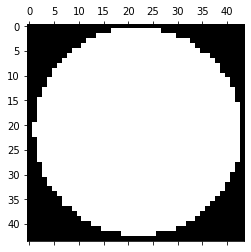

In [103]:
# Generate the circular mask, using the same coordinates determined above.
mask = py4DSTEM.process.dpc.make_circular_mask(shape = (dataset.Q_Nx,dataset.Q_Ny),
                                               qxy0 = (qx0, qy0),
                                               radius = probe_semiangle + expand_BF)
    
# Plot the mask
py4DSTEM.visualize.show(mask, figsize=(4,4))

In [109]:
# Calculate the center of mass for all probe positions
CoMx, CoMy = py4DSTEM.process.dpc.get_CoM_images(dataset, mask=mask)

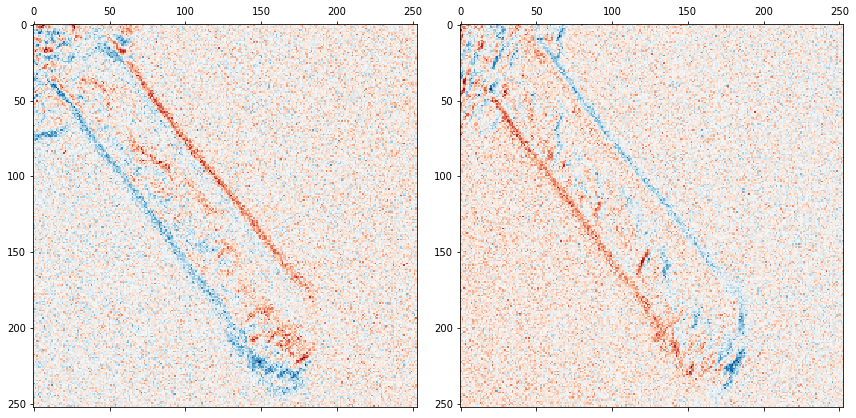

In [117]:
# Plot the 2 CoM outputs, the x and y directions
py4DSTEM.visualize.show_image_grid(
    lambda i:[CoMx, CoMy][i],
    H=1,
    W=2,
    cmap='RdBu')

These images are significantly clearer than the virtual BF image!  

Ideally, CoMx measures the beam deflection in the vertical direction.  As the probe scans downwards, we expect it to deflect in the positive direction (red) as it hits the edge of the sample, and then in the negative direction (blue as it leaves the sample). This is what we observe in the left plot. Similarly, the CoMy signal should show a positive and then negative deflection, as it scans from the left hand edge of the field of view to the right. This is also what we see in the above right side image. 

Therefore, it's likely that the scan directions of this experiment are properly aligned to the diffraction space image coordinates. We will however check this assumption in the next section. We will plot one more output first, the total gradient magnitude sqrt(CoMx^2 + CoMy^2), which is equal to the magnitude of the electric field at each probe position.

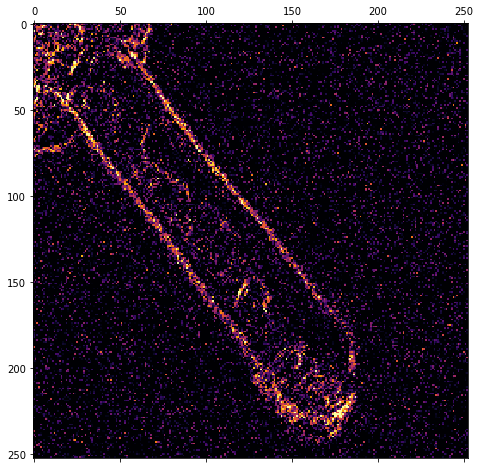

In [138]:
# Plot the gradient magnitude, from -1 to +5 standard deviations
py4DSTEM.visualize.show(np.sqrt(CoMx**2 + CoMy**2),
                       cmap='inferno',
                       clipvals='std',
                       min=-0.5,
                       max=4.5)